{'Employee_Name': 311, 'EmpID': 310, 'MarriedID': 1, 'MaritalStatusID': 4, 'GenderID': 1, 'EmpStatusID': 4, 'DeptID': 5, 'PerfScoreID': 3, 'FromDiversityJobFairID': 1, 'Salary': 204954, 'Termd': 1, 'PositionID': 29, 'Position': 32, 'State': 28, 'Zip': 158, 'DOB': 307, 'Sex': 2, 'MaritalDesc': 5, 'CitizenDesc': 3, 'HispanicLatino': 4, 'RaceDesc': 6, 'DateofHire': 101, 'DateofTermination': 97, 'TermReason': 18, 'EmploymentStatus': 3, 'Department': 6, 'ManagerName': 21, 'ManagerID': 38.0, 'RecruitmentSource': 9, 'PerformanceScore': 4, 'EngagementSurvey': 3.88, 'EmpSatisfaction': 4, 'SpecialProjectsCount': 8, 'LastPerformanceReview_Date': 137, 'DaysLateLast30': 6, 'Absences': 19}


,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences
310,"Zima, Colleen",10271,0,4,0,1,5,3,0,45046,...,Production,David Stanley,14.0,LinkedIn,Fully Meets,4.50,5,0,0,2
140,"Jacobi, Hannah",10236,0,2,0,1,5,3,0,45069,...,Production,Kissy Sullivan,20.0,Employee Referral,Fully Meets,4.30,5,0,0,7
231,"Rhoads, Thomas",10058,0,2,1,5,5,3,0,45115,...,Production,Elijiah Gray,16.0,LinkedIn,Fully Meets,5.00,4,0,0,11
176,"Mahoney, Lauren",10219,0,0,0,1,5,3,0,45395,...,Production,Ketsia Liebig,19.0,LinkedIn,Fully Meets,4.60,4,0,0,14
152,"Kirill, Alexandra",10170,1,1,0,5,5,3,0,45433,...,Production,Amy Dunn,11.0,Google Search,Fully Meets,3.49,4,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,"Corleone, Vito",10019,0,0,1,1,5,4,0,170500,...,Production,Janet King,2.0,Indeed,Exceeds,3.70,5,0,0,15
96,"Foss, Jason",10015,0,0,1,1,3,4,0,178000,...,IT/IS,Jennifer Zamora,5.0,Indeed,Exceeds,5.00,5,5,0,15
131,"Houlihan, Debra",10272,1,1,0,1,6,3,0,180000,...,Sales,Janet King,2.0,LinkedIn,Fully Meets,4.50,4,0,0,19
308,"Zamora, Jennifer",10010,0,0,0,1,3,4,0,220450,...,IT/IS,Janet King,2.0,Employee Referral,Exceeds,4.60,5,6,0,16


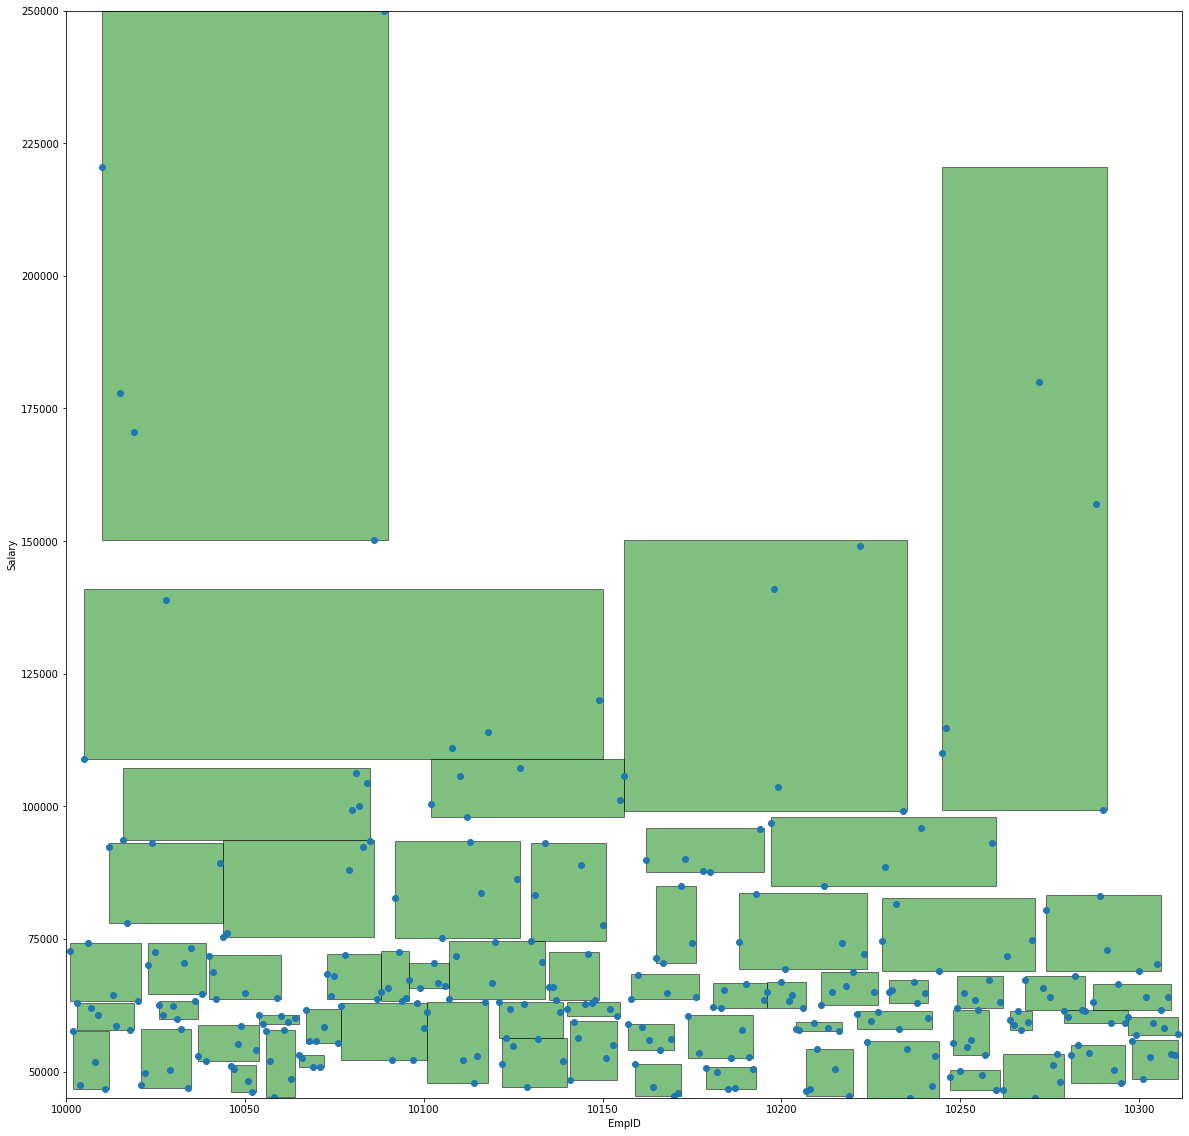

In [6]:
import hits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

df_main = pd.read_csv("./data/HRDataset_v14.csv")
categorical = set(('Employee_Name','Position', 'State', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'DateofHire', 'DateofTermination','TermReason' ,'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore', 'LastPerformanceReview_Date' ))

def split(df_main, partition, column):
    dfp = df_main[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

def get_spans(df_main, partition, scale=None):
    spans = {}
    for column in df_main.columns:
        if column in categorical:
            span = len(df_main[column][partition].unique())
        else:
            span = df_main[column][partition].max()-df_main[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

def is_k_anonymous(df_main, partition, sensitive_column, k=3):
    if len(partition) < k:
        return False
    return True

def partition_dataset(df_main, feature_columns, sensitive_column, scale, is_valid):
    finished_partitions = []
    partitions = [df_main.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df_main[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df_main, partition, column)
            if not is_valid(df_main, lp, sensitive_column) or not is_valid(df_main, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

for name in categorical:
    df_main[name] = df_main[name].astype('category')

full_spans = get_spans(df_main, df_main.index)
print(full_spans)


feature_columns = ['EmpID', 'Salary']
sensitive_column = 'Salary'
finished_partitions = partition_dataset(df_main, feature_columns, sensitive_column, full_spans, is_k_anonymous)

categorical_drop = set(('Employee_Name','Position', 'State', 'Zip', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc','TermReason' ,'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore' ))


def build_indexes(df_main):
    indexes = {}
    for column in categorical_drop:
        values = sorted(df_main[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df_main, column, partition, indexes, offset=0.1):
    if column in categorical_drop:
        sv = df_main[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df_main[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df_main[df_main[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df_main, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df_main, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df_main, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df_main, column, indexes, offset=1.0):
    if column in categorical_drop:
        return 0-offset, len(indexes[column])+offset
    return df_main[column].min()-offset, df_main[column].max()+offset

df_main.drop('DOB', axis=1, inplace=True)
df_main.drop('LastPerformanceReview_Date',  axis=1, inplace=True)
df_main.drop('DateofTermination', axis=1, inplace=True)
df_main.drop('DateofHire',  axis=1, inplace=True)

indexes = build_indexes(df_main)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df_main, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

def plot_rects(df_main, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df_main, column_x, indexes))
    ax.set_ylim(*get_bounds(df_main, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
    
    
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
plot_rects(df_main, ax, rects, column_x, column_y, facecolor='g')
plt.scatter(df_main[column_x], df_main[column_y])
# plt.show()

df_main.sort_values([sensitive_column])